<a href="https://colab.research.google.com/github/kylawolski/GGIS527_Final_Project_Wolski/blob/main/GGIS527_FinalProject_KylaWolski_HarrisCounty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assessing Social Vulnerability and Flooding Impacts in Harris County, TX Neighborhoods**

Kyla Wolski

GGIS 527 Final Project

Fall 2025

In [ ]:
#!pip install mapclassify pysal geodatasets --quiet

In [ ]:
# import required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium import Choropleth
import geodatasets
import numpy as np
import seaborn as sns
from sklearn.preprocessing import robust_scale
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from pysal.lib import weights
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# data collection

# flood hazard data from FEMA NFHL (national flood hazard layer) last updated June 2024
fema = gpd.read_file("S_FLD_HAZ_AR.shp")
fema = fema.to_crs(4326)

In [ ]:
# census data from ACS 2022 5 year estimates, downloaded via Social Explorer
census_data = gpd.read_file("harris.csv")

In [ ]:
# for being able to plot the census tract data on a map,
# used the TIGER/line shapefile for illinois census tracts 2023

tracts = gpd.read_file("tl_2023_48_tract.shp")
tracts = tracts[tracts["COUNTYFP"] == "201"]
# set the projection
tracts = tracts.to_crs(4326)

In [ ]:
# data merging/cleanup

In [ ]:
# for FEMA flood zones
fema_filtered = fema[[
    "FLD_ZONE",     # FEMA flood zone (A, AE, AO, AH, VE, X)
    "SFHA_TF",      # in 100 ye floodplain? (True/False)
    "STATIC_BFE",   # base flood elevation (water surface height during 1% flood)
    "DEPTH",        # flood depth for shallow zones (AO/AH)
    "STUDY_TYP",    # type of flood study (FIS = flood ins study, D= detailed, L=limited, NONS)
    "geometry"      # polygon
]]

# key for what each flood zone means:
# AE – 1% annual chance (100-yr); BFE determined
# A – 1% annual chance; no BFE
# AH / AO – Shallow flooding (ponding/sheet flow)
# VE – Coastal high-hazard
# X – Outside 1% flood zone (minimal risk)
# 0.2 PCT ANNUAL CHANCE – 500-yr flood zone

In [ ]:
# for census data
# filtering for columns I want to use for assessing social vulnerability for flooding

# the columns I want:
# geo info, Population Density (Per Sq. Mile), % Total Population over 65, % under age five, % with less than high school edu,
# % below poverty level, % no health insurance coverage,% occupied housing units no vehicle available, % total population white alone
# Note: combine % Total Population: 65 to 74 Years, % Total Population: 75 to 84 Years, and % Total Population: 85 Years and Over
# and omit the first row

census_filtered = census_data[[
    "State (FIPS Code)",
    "County of current residence",
    "Census Tract",
    "Geographic Identifier",
    "FIPS",
    "Population Density (Per Sq. Mile)",
    "% Total Population: Under 5 Years",
    "% Total Population: 65 to 74 Years",
    "% Total Population: 75 to 84 Years",
    "% Total Population: 85 Years and Over",
    "% Total Population: White Alone",
    "% Population 25 Years and Over: Less than High School",
    "% Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty",
    "% Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty",
    "% Occupied Housing Units: No Vehicle Available",
    "Per Capita Income (In 2023 Inflation Adjusted Dollars)"
]]

census_filtered["% Total Population: 65 Years and Over"] = census_filtered["% Total Population: 65 to 74 Years"] + census_filtered["% Total Population: 75 to 84 Years"] + census_filtered["% Total Population: 85 Years and Over"]
census_filtered["% Population 18 Years and Over: Living in Poverty"] = census_filtered["% Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty"] + census_filtered["% Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty"]
census_filtered = census_filtered.drop(0)
census_filtered = census_filtered.drop(columns=["% Total Population: 65 to 74 Years", "% Total Population: 75 to 84 Years", "% Total Population: 85 Years and Over", "% Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty", "% Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty"])

/tmp/ipython-input-879552250.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_filtered["% Total Population: 65 Years and Over"] = census_filtered["% Total Population: 65 to 74 Years"] + census_filtered["% Total Population: 75 to 84 Years"] + census_filtered["% Total Population: 85 Years and Over"]
/tmp/ipython-input-879552250.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_filtered["% Population 18 Years and Over: Living in Poverty"] = census_filtered["% Population Age 18 to 64 for Wh

In [ ]:
# merge the census data to the tracts shapefile for plotting
merged = tracts.merge(census_filtered, left_on="GEOID", right_on="FIPS", how="left")

In [ ]:
# convert all columns except GEOID and geometry to numeric
# and give a value of zero if nan
for col in merged.columns:
    if col not in ["GEOID", 'geometry']:
        merged[col] = pd.to_numeric(merged[col], errors="coerce").fillna(0)

In [ ]:
# initial data exploration

Text(0.5, 1.0, 'FEMA Flood Zones for Harris County')

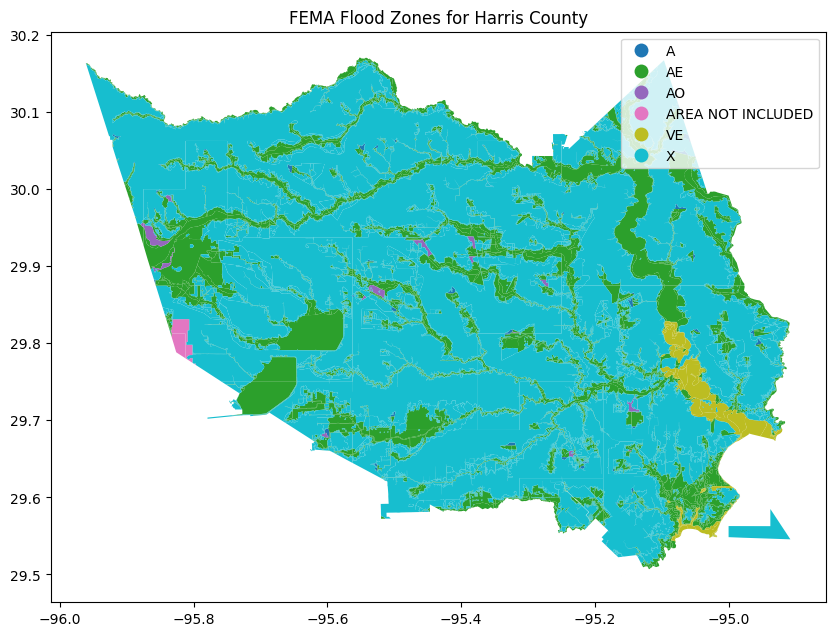

In [ ]:
fema_filtered.plot(column="FLD_ZONE", legend=True, categorical=True, figsize=(10, 10))
plt.title("FEMA Flood Zones for Harris County")

Text(0.5, 1.0, 'In 100 Year Flood True/False For Harris County')

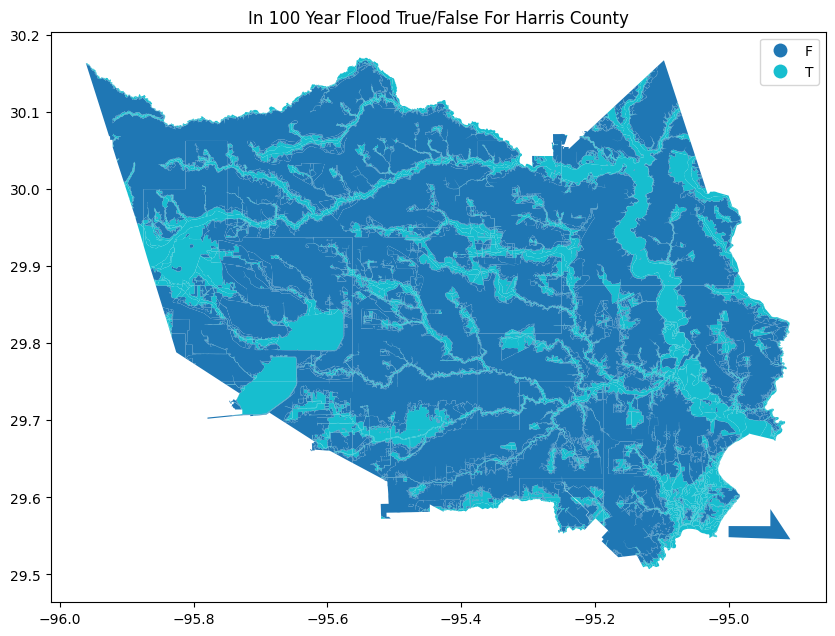

In [ ]:
fema_filtered.plot(column="SFHA_TF", legend=True, categorical=True, figsize=(10, 10))
plt.title("In 100 Year Flood True/False For Harris County")

Text(0.5, 1.0, 'Harris County base flood elevation (water surface height during 100 year flood)')

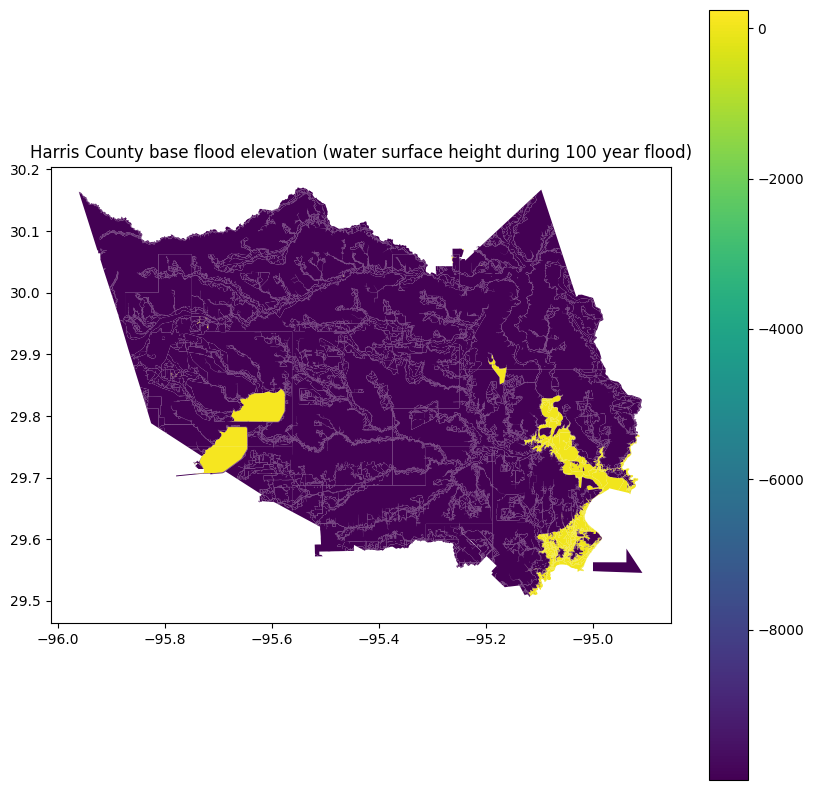

In [ ]:
fema_filtered.plot(column="STATIC_BFE", legend=True, figsize=(10, 10))
plt.title("Harris County base flood elevation (water surface height during 100 year flood)")

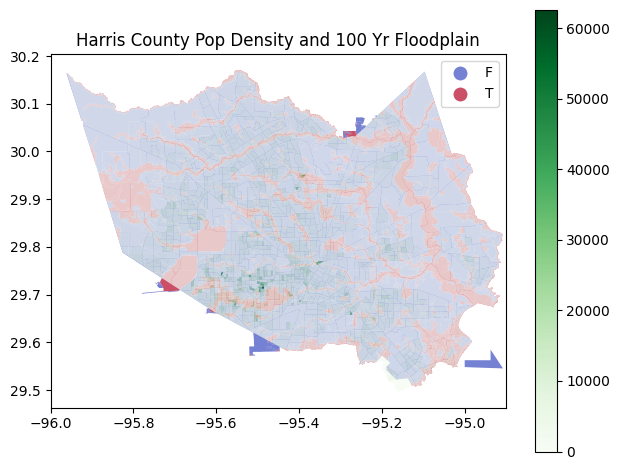

In [ ]:
fema_filtered = fema_filtered.to_crs(4326)
ax = fema_filtered.plot(color="white", alpha=0.2)
fema_filtered.plot(ax=ax, column="SFHA_TF", cmap="coolwarm", alpha=0.7, legend=True)
merged.plot(ax=ax, column="Population Density (Per Sq. Mile)", cmap="Greens", alpha=0.7, legend=True)
plt.xlim(-96, -94.9)
plt.title("Harris County Pop Density and 100 Yr Floodplain")
plt.tight_layout()

In [ ]:
m = folium.Map(location=[29.76, -95.37], zoom_start=10)

Choropleth(
    geo_data=merged,
    data=merged,
    columns=["GEOID", "% Population 25 Years and Over: Less than High School"],
    key_on="feature.properties.GEOID",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="% Population 25 Years and Over: Less than High School",
).add_to(m)

m

In [ ]:
# use clustering for at socially vulnerable and at risk of flooding areas

In [ ]:
cluster_variables = [
    "% Population 18 Years and Over: Living in Poverty",
    "% Total Population: 65 Years and Over",
    "% Total Population: Under 5 Years",
    "% Population 25 Years and Over: Less than High School",
    "% Total Population: White Alone",
    "% Occupied Housing Units: No Vehicle Available",
    "Population Density (Per Sq. Mile)"
]

In [ ]:
merged[cluster_variables].describe()

% Population 18 Years and Over: Living in Poverty  \
count                                        1115.000000   
mean                                           18.125123   
std                                           190.228524   
min                                             0.000000   
25%                                             0.000000   
50%                                             0.000000   
75%                                             0.000000   
max                                          2838.270000   

       % Total Population: 65 Years and Over  \
count                            1115.000000   
mean                                0.836593   
std                                13.146708   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 0.000000   
max                               300.000000   

       % Total Population: Under 5 Years  \
count                        1115.000000   
mean                            6.705345   
std                             3.630656   
min                             0.000000   
25%                             4.280000   
50%                             6.330000   
75%                             8.575000   
max                            23.070000   

       % Population 25 Years and Over: Less than High School  \
count                                        1115.000000       
mean                                           19.043740       
std                                            16.110959       
min                                             0.000000       
25%                                             5.180000       
50%                                            14.860000       
75%                                            30.115000       
max                                            71.580000       

       % Total Population: White Alone  \
count                      1115.000000   
mean                         39.451202   
std                          20.939391   
min                           0.000000   
25%                          22.545000   
50%                          36.810000   
75%                          55.405000   
max                         100.000000   

       % Occupied Housing Units: No Vehicle Available  \
count                                     1115.000000   
mean                                         7.580807   
std                                          8.242943   
min                                          0.000000   
25%                                          1.355000   
50%                                          4.930000   
75%                                         10.710000   
max                                         48.940000   

       Population Density (Per Sq. Mile)  
count                        1115.000000  
mean                         6329.674504  
std                          5593.069961  
min                             0.000000  
25%                          3134.065519  
50%                          5114.166612  
75%                          7350.727329  
max                         62579.264106

In [ ]:
# Data normalization with robust scaling
gdf_scaled = robust_scale(merged[cluster_variables])

# Convert the scaled array back into a DataFrame
gdf_scaled_df = pd.DataFrame(gdf_scaled, columns=cluster_variables)

# Display summary statistics
gdf_scaled_df.describe()

% Population 18 Years and Over: Living in Poverty  \
count                                        1115.000000   
mean                                           18.125123   
std                                           190.228524   
min                                             0.000000   
25%                                             0.000000   
50%                                             0.000000   
75%                                             0.000000   
max                                          2838.270000   

       % Total Population: 65 Years and Over  \
count                            1115.000000   
mean                                0.836593   
std                                13.146708   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 0.000000   
max                               300.000000   

       % Total Population: Under 5 Years  \
count                        1115.000000   
mean                            0.087391   
std                             0.845322   
min                            -1.473807   
25%                            -0.477299   
50%                             0.000000   
75%                             0.522701   
max                             3.897555   

       % Population 25 Years and Over: Less than High School  \
count                                        1115.000000       
mean                                            0.167786       
std                                             0.646118       
min                                            -0.595949       
25%                                            -0.388209       
50%                                             0.000000       
75%                                             0.611791       
max                                             2.274714       

       % Total Population: White Alone  \
count                      1115.000000   
mean                          0.080377   
std                           0.637230   
min                          -1.120207   
25%                          -0.434114   
50%                           0.000000   
75%                           0.565886   
max                           1.923007   

       % Occupied Housing Units: No Vehicle Available  \
count                                     1115.000000   
mean                                         0.283357   
std                                          0.881127   
min                                         -0.526991   
25%                                         -0.382149   
50%                                          0.000000   
75%                                          0.617851   
max                                          4.704436   

       Population Density (Per Sq. Mile)  
count                        1115.000000  
mean                            0.288263  
std                             1.326421  
min                            -1.212847  
25%                            -0.469590  
50%                             0.000000  
75%                             0.530410  
max                            13.628102

In [ ]:
# k-means

# Run K-Means clustering (3 clusters)
np.random.seed(0)
kmeans = KMeans(n_clusters=3)
k3cls = kmeans.fit(gdf_scaled)

# Store cluster labels and check cluster sizes
merged['k3cls'] = kmeans.labels_
merged.groupby('k3cls').size()

k3cls
0    1109
1       4
2       2
dtype: int64

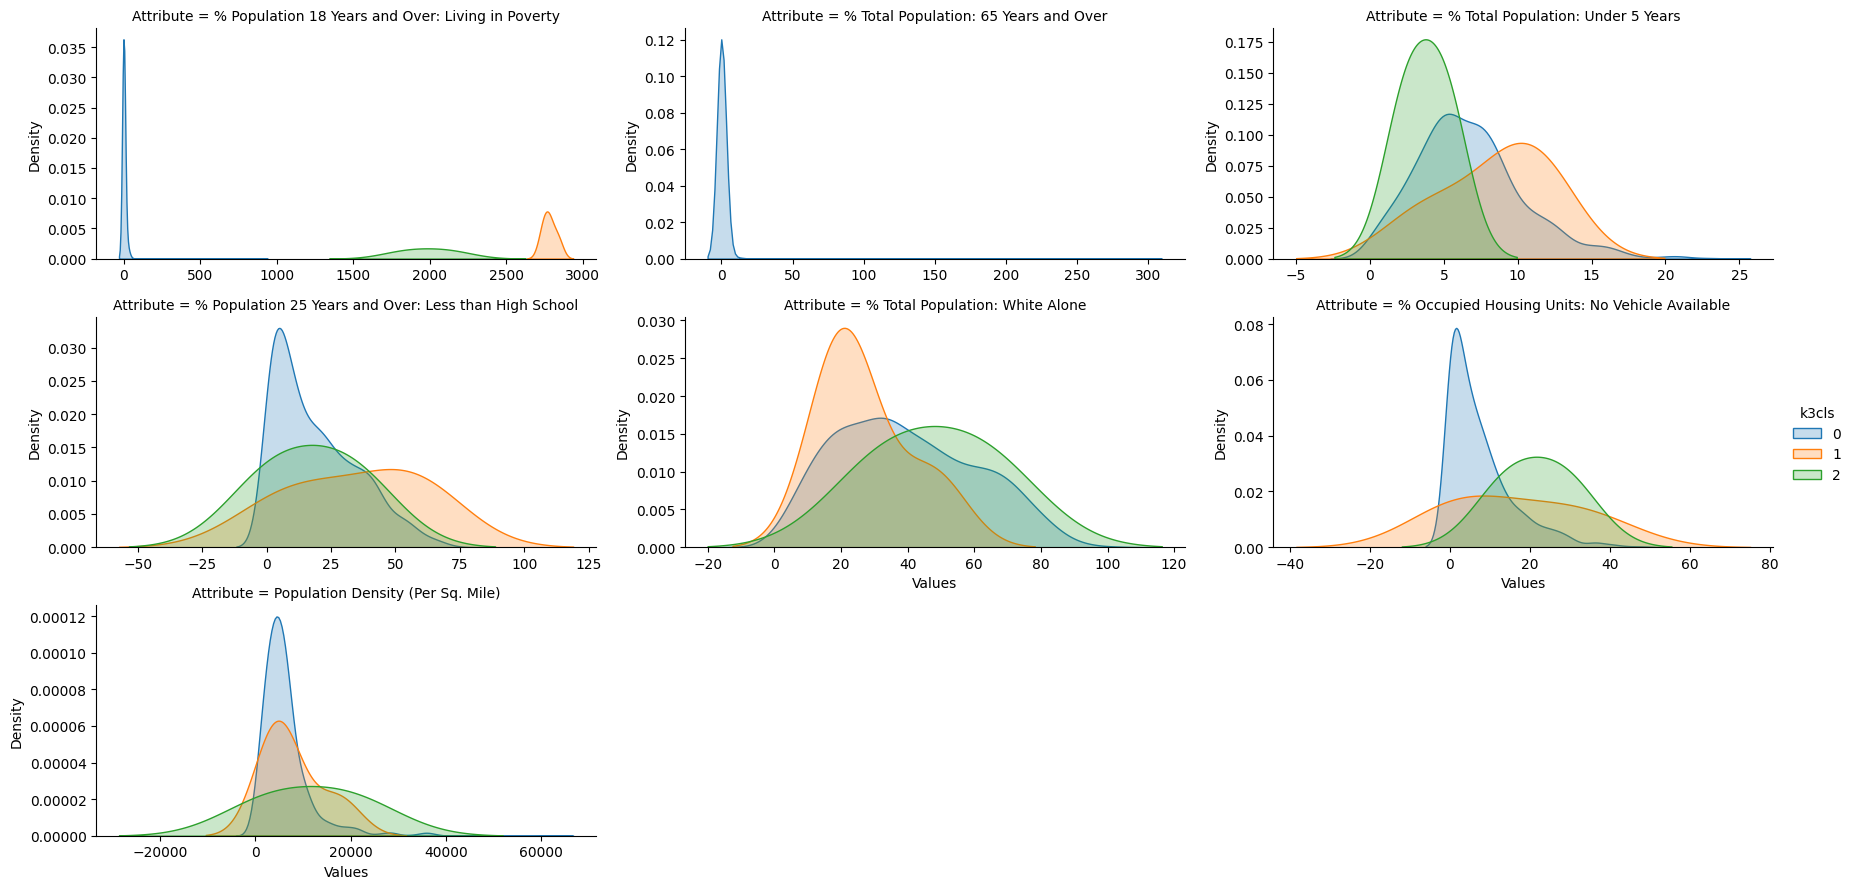

In [ ]:
# Reindex by cluster ID and select clustering variables
tidy_db = merged.set_index("k3cls")[cluster_variables]

# Convert to long format for easier plotting
tidy_db = tidy_db.stack().reset_index()
tidy_db = tidy_db.rename(columns={"level_1": "Attribute", 0: "Values"})

# Preview transformed data
tidy_db.head()

# Create KDE plots by cluster for each attribute
facets = sns.FacetGrid(
    data=tidy_db, col="Attribute", hue="k3cls", sharey=False,
    sharex=False, aspect=2, col_wrap=3
)
_ = facets.map(sns.kdeplot, "Values", fill=True, warn_singular=False).add_legend()

In [ ]:
# Map numeric cluster labels to descriptive names
cluster_names = {
    0: "Least vulnerable in this case",
    1: "Most vulnerable in this case",
    2: "Moderately vulnerable in this case"
}

# Create a new column with the descriptive cluster names
merged['cluster_name'] = merged['k3cls'].map(cluster_names)

In [ ]:
# hierarchical clustering

# Perform hierarchical clustering (Ward linkage) with 3 clusters
np.random.seed(0)
model = AgglomerativeClustering(linkage="ward", n_clusters=3)
model.fit(gdf_scaled)

# Store cluster labels and check cluster sizes
merged["ward3"] = model.labels_
merged.groupby("ward3").size()

ward3
0       6
1    1107
2       2
dtype: int64

In [ ]:
# regionalization

# Generate spatial weights (Queen contiguity)
np.random.seed(0)
w = weights.Queen.from_dataframe(merged)

# Perform hierarchical clustering with spatial connectivity constraint
model = AgglomerativeClustering(linkage="ward", connectivity=w.sparse, n_clusters=3)
model.fit(gdf_scaled)

# Store cluster labels and check cluster sizes
merged["ward3wq"] = model.labels_
merged.groupby('ward3wq').size()

/tmp/ipython-input-2519428702.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(merged)


ward3wq
0    1113
1       1
2       1
dtype: int64

In [ ]:
# gepgraphical coherence
results = []
for cluster_type in ("k3cls", "ward3", "ward3wq"):
    # compute the region polygons using a dissolve
    regions = merged[[cluster_type, "geometry"]].dissolve(by=cluster_type)
    # compute the actual isoperimetric quotient for these regions
    ipqs = (
        regions.area * 4 * np.pi / (regions.boundary.length ** 2)
    )
    # cast to a dataframe
    result = ipqs.to_frame(cluster_type)
    results.append(result)
# stack the series together along columns
pd.concat(results, axis=1)

/tmp/ipython-input-617980649.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regions.area * 4 * np.pi / (regions.boundary.length ** 2)
/tmp/ipython-input-617980649.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regions.area * 4 * np.pi / (regions.boundary.length ** 2)
/tmp/ipython-input-617980649.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regions.area * 4 * np.pi / (regions.boundary.length ** 2)
/tmp/ipython-input-617980649.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geomet

k3cls     ward3   ward3wq
0  0.308809  0.126237  0.344835
1  0.170477  0.291400  0.521642
2  0.471951  0.274046  0.697480

In [ ]:
# feature coherence

ch_scores = []
for cluster_type in ("k3cls", "ward3", "ward3wq"):
    # compute the CH score
    ch_score = calinski_harabasz_score(
        # using scaled variables
        robust_scale(merged[cluster_variables]),
        # using these labels
        merged[cluster_type],
    )
    # and append the cluster type with the CH score
    ch_scores.append((cluster_type, ch_score))

# re-arrange the scores into a dataframe for display
pd.DataFrame(
    ch_scores, columns=["cluster type", "CH score"]
).set_index("cluster type")

CH score
cluster type              
k3cls         10447.659745
ward3         17531.137906
ward3wq         349.447506

In [ ]:
# merge the flood and acs data together
gdf = gpd.sjoin(merged, fema_filtered, how="left", predicate="intersects")

# only include areas designated in the 100 year floodplain if doing visualizations of clusters
# gdf = gdf[gdf["SFHA_TF"] == "T"]

In [ ]:
# visualize k-means within the 100 year flooplain
#gdf.explore(column='k3cls', categorical=True, legend_kwds={'caption': 'Cluster'})

In [ ]:
#gdf.explore(column='ward3wq', categorical=True, legend_kwds={'caption': 'Cluster'})

In [ ]:
# make the flood zones numeric values
gdf['FLD_ZONE'].unique()

array(['X', 'AE', 'A', 'AO', 'VE', 'AREA NOT INCLUDED', nan], dtype=object)

In [ ]:
risk_map = {
    "VE": 5,
    "AO": 4,
    "AE": 3,
    "A": 2,
    "X": 1,
    "AREA NOT INCLUDED": 0
}

# Apply the map
gdf["risk_value"] = gdf["FLD_ZONE"].map(risk_map).fillna(0)
#gdf["risk_value"]

In [ ]:
# load the NFIP claims dataset last updated nov 19 2025 https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v2
# now using different years, however --> this could lead to bias an/or innacurate results?
df_claims = gpd.read_file('FimaNfipClaims.csv')

In [ ]:
# filter flood ins claims for IL and get total damage amount for each event
df_tx_claims = df_claims[df_claims['state'] == 'TX']
df_tx_claims['buildingDamageAmount'] = df_tx_claims['buildingDamageAmount'].fillna(0)
df_tx_claims['contentsDamageAmount'] = df_tx_claims['contentsDamageAmount'].fillna(0)
df_tx_claims['totalDamageAmount'] = df_tx_claims['buildingDamageAmount'] + df_tx_claims['contentsDamageAmount']

/tmp/ipython-input-499413813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tx_claims['buildingDamageAmount'] = df_tx_claims['buildingDamageAmount'].fillna(0)
/tmp/ipython-input-499413813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tx_claims['contentsDamageAmount'] = df_tx_claims['contentsDamageAmount'].fillna(0)
/tmp/ipython-input-499413813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [ ]:
df_tx_claims = df_tx_claims[['totalDamageAmount', 'latitude', 'longitude']]

In [ ]:
# for claims convert lat lon to points in order to use geometry and spatial join w census data

df_tx_claims["totalDamageAmount"] = pd.to_numeric(df_tx_claims["latitude"], errors="coerce")
df_tx_claims["latitude"] = pd.to_numeric(df_tx_claims["latitude"], errors="coerce")
df_tx_claims["longitude"] = pd.to_numeric(df_tx_claims["longitude"], errors="coerce")

# create geometry
df_tx_claims["geometry"] = df_tx_claims.apply(
    lambda row: Point(row["longitude"], row["latitude"]),
    axis=1
)

# convert to GeoDataFrame with correct CRS
df_tx_claims = gpd.GeoDataFrame(
    df_tx_claims,
    geometry="geometry",
    crs="EPSG:4326"
)


In [ ]:
# need to rename before joining so there are not two index_rights
gdf = gdf.rename(columns={"index_right": "gdf_index"})

joined = gpd.sjoin(
    df_tx_claims,
    gdf,
    how="left",
    predicate="within"
)

In [ ]:
# X = predictors
X = joined[[
    "risk_value",
    "% Population 18 Years and Over: Living in Poverty",
    "% Total Population: 65 Years and Over",
    "% Total Population: Under 5 Years",
    "% Population 25 Years and Over: Less than High School",
    "% Total Population: White Alone",
    "% Occupied Housing Units: No Vehicle Available",
    "Population Density (Per Sq. Mile)"
]].fillna(0)

# y = target
y = joined["totalDamageAmount"] # the damage amount is in whole dollars

In [ ]:
# change nans to 0 (kept getting a lot of errors with this when trying to run the random forest model)
cols = joined.columns.drop("geometry")
joined[cols] = joined[cols].apply(pd.to_numeric, errors="coerce").fillna(0)
y = y.fillna(0)
y.isna().sum()

np.int64(0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1458, 8)
Shape of X_test: (365, 8)
Shape of y_train: (1458,)
Shape of y_test: (365,)


In [ ]:
# Initialize the Random Forest Regressor
random_forest_model = RandomForestRegressor(random_state=42)

# Train the model
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model using RMSE
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)

print(f"Random Forest - Root Mean Squared Error (RMSE): {rmse_rf}")

Random Forest - Root Mean Squared Error (RMSE): 0.34612106184466335


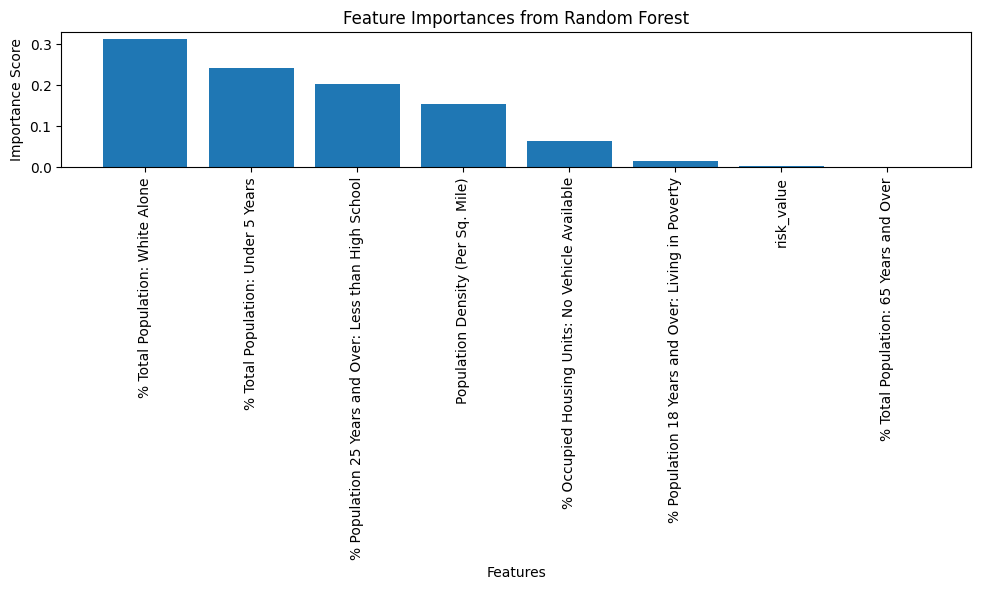

In [ ]:
# Get feature importances from the trained Random Forest model
feature_importances_rf = random_forest_model.feature_importances_

# Create a pandas Series for better visualization
feature_importance_series_rf = pd.Series(feature_importances_rf, index=X_train.columns)

# Sort the features by importance in descending order
ranked_feature_importances_rf = feature_importance_series_rf.sort_values(ascending=False)

# Plot the ranked feature importances as a vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(ranked_feature_importances_rf.index, ranked_feature_importances_rf.values)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()